In [2]:
import cv2
import numpy as np
import mediapipe as mp
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

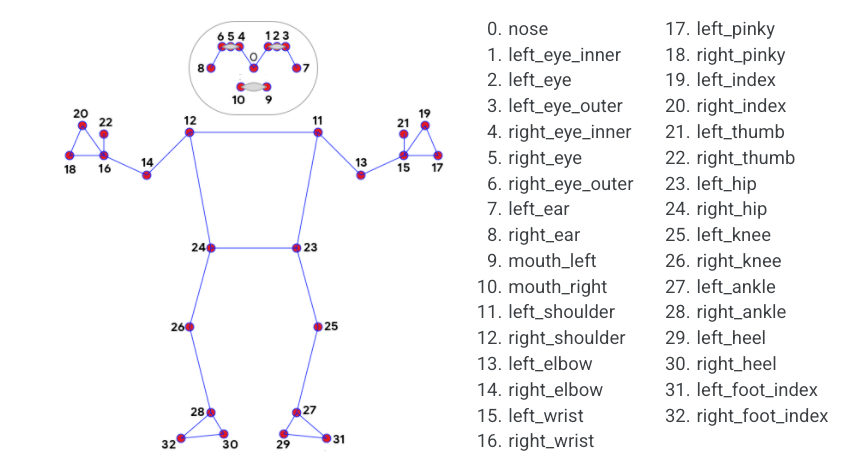

In [3]:
import sys  
sys.path.insert(0, 'C:/Users/Nguyễn Hoài Nam/OneDrive/CDIO4')
from pose_media import mediapipe_pose

In [4]:
mp = mediapipe_pose()

In [5]:
X = np.load("X1.npy")
y = np.load("y1.npy")
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

#Load model
new_model = tf.keras.models.load_model('action1.h5')

In [6]:
X_train.shape,y_train.shape

((5683, 30, 132), (5683, 4))

In [9]:
actions = np.array(["HANDCLAPPING","RUNNING","WALKING","STANDING"])
sequence,sentence,prediction = [],[],[]
threshold = 0.7
pTime,cTime = 0,0
cap = cv2.VideoCapture("test/1.mp4")
#Thiết lập model
with mp.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # ĐỌC
        ret, frame = cap.read()

        # Make detections
        try:
            image, results = mp.mediapipe_detection(frame, holistic)
        except:
            break
        
        # Draw landmarks
        mp.draw_styled_landmarks(image, results)
        bbox = mp.BBox(image,results)
        cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(245, 117, 16), 2)

        keypoints = mp.extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = new_model.predict(np.expand_dims(sequence, axis=0))[0]
            prediction.append([np.argmax(res)])
            print(actions[np.argmax(res)])
            
            
            if np.unique(prediction[-10:])[0] ==  np.argmax(res): 
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1: 
                sentence = sentence[-1:]
            for num, prob in enumerate(res):
                print(prob)
                cv2.rectangle(image, (0,60+num*40), (int(prob*100), 80+num*40), (245, 117, 16), -1)
                cv2.putText(image, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        #FPS
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(image,"FPS:" +str(int(fps)),(500,100), cv2.FONT_HERSHEY_PLAIN, 2,(255,0,190),2,cv2.LINE_AA)

        


        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

WALKING
1.9926547e-05
0.03443659
0.96553373
9.764098e-06
WALKING
2.0263082e-05
0.029605288
0.97036463
9.808309e-06
WALKING
1.8011782e-05
0.02322015
0.9767528
8.999276e-06
WALKING
1.4781458e-05
0.020341199
0.9796357
8.264095e-06
WALKING
2.525127e-05
0.1637274
0.8362332
1.4212594e-05
